### Import Packages


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *


Using TensorFlow backend.


### Read in datafile

In [139]:
train = pd.read_csv("TIL_NLP_train_dataset.csv")
test = pd.read_csv("TIL_NLP_test_dataset.csv")
print(train.shape)
print(test.shape)

(7380, 7)
(2460, 2)


In [3]:
train.head(3) ##Inpect

,id,word_representation,outwear,top,trousers,women dresses,women skirts
0,0,w7718 w173355 w138132 w232277 w90685 w314686 w...,1,0,1,0,0
1,1,w195317 w127737 w171593 w22890 w342007 w217871...,1,0,1,0,0
2,2,w247655 w270233 w261113 w337250 w366000 w37873...,0,1,1,0,0


In [43]:
test.head(3) ##Inpect

,id,word_representation
0,0,w373517 w383437 w374393 w87179 w289496 w327385...
1,1,w237465 w167111 w279437 w194870 w351537 w17560...
2,2,w151648 w93366 w121255 w193800 w71240 w48576 w...


### Extract input and labels

In [140]:
train_input = train["word_representation"]
train_labels = train[train.columns[2:]]
test_input = test["word_representation"]
test_id = test["id"]

print(train_input.head(1))
print(train_labels.head(1))
print(test_input.head(1))

0    w7718 w173355 w138132 w232277 w90685 w314686 w...
Name: word_representation, dtype: object
   outwear  top  trousers  women dresses  women skirts
0        1    0         1              0             0
0    w373517 w383437 w374393 w87179 w289496 w327385...
Name: word_representation, dtype: object


### Tokenise and pad

In [132]:
x_train, x_test, y_train, y_test = train_test_split(train_input, train_labels, test_size=0.15, shuffle = True, random_state = 255)

BATCH_SIZE = 256
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.15

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(list(x_train))
embedded_sentence = tokenizer.texts_to_sequences(x_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(embedded_sentence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

data_train, val_test, data_label, val_label = train_test_split(data, y_train, test_size=0.10, shuffle = True, random_state = 67)

Found 4036 unique tokens.


In [58]:
data

array([[ 24, 293, 528, ...,   0,   0,   0],
       [135, 164, 276, ...,   0,   0,   0],
       [  2, 277, 122, ...,   0,   0,   0],
       ...,
       [699,  26, 111, ...,   0,   0,   0],
       [422, 101,   5, ...,   0,   0,   0],
       [134, 620,   9, ...,   0,   0,   0]])

In [50]:
print(val_test.shape)
print(val_label.shape)
print(data_train.shape)
print(data_label.shape)

(628, 100)
(628, 5)
(5645, 100)
(5645, 5)


### Create embedding dictionary and matrix

In [7]:
### Read pkl file provided
import pickle 
with open("word_embeddings.pkl",'rb') as g:
    word_embedding = pickle.load(g)

In [8]:
### Check if correct
len(word_embedding) 

400000

In [75]:
type(word_embedding)

dict

In [133]:
### Construct the matrix for the words in the test-set
embedding_mat = np.zeros((len(word_index)+1,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = word_embedding.get(word)
    if embedding_vector is not None:
        embedding_mat[index] = embedding_vector
        
embedding_mat.shape

(4037, 100)

In [11]:
# model = Sequential()
# embedding_layer = Embedding(len(word_index)+1,100, weights = [embedding_mat], 
#                             input_length = MAX_SEQUENCE_LENGTH, trainable = False)
# model.add(embedding_layer)
# model.add(Conv1D(512, 6, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(5))
# model.add(Conv1D(256, 2, activation='relu'))
# model.add(Dropout(0.3))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(5, activation='softmax'))


In [34]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print(model.summary())


In [13]:
history = model.fit(data_train, data_label, epochs=5, batch_size=256, validation_data=(val_test, val_label), verbose=1)

Train on 5645 samples, validate on 628 samples
Epoch 1/5
5645/5645 [==============================] - 9s 2ms/sample - loss: 0.8410 - accuracy: 0.6503 - val_loss: 0.6474 - val_accuracy: 0.6462
Epoch 2/5
5645/5645 [==============================] - 10s 2ms/sample - loss: 0.5868 - accuracy: 0.6594 - val_loss: 0.5780 - val_accuracy: 0.6503
Epoch 3/5
5645/5645 [==============================] - 9s 2ms/sample - loss: 0.4875 - accuracy: 0.7438 - val_loss: 0.4836 - val_accuracy: 0.7182
Epoch 4/5
5645/5645 [==============================] - 8s 2ms/sample - loss: 0.4264 - accuracy: 0.7899 - val_loss: 0.4454 - val_accuracy: 0.7360
Epoch 5/5
5645/5645 [==============================] - 9s 2ms/sample - loss: 0.3960 - accuracy: 0.7984 - val_loss: 0.4170 - val_accuracy: 0.7500


In [134]:
tokens_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64', name="SentencesInput")
embedded_sequences = Embedding(len(word_index)+1,100, weights = [embedding_mat], 
                             input_length = MAX_SEQUENCE_LENGTH, trainable = False)(tokens_input)
x = Conv1D(512, 5, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(256, 2, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
final = Dense(5, activation='sigmoid')(x)

model = Model(inputs=[tokens_input], outputs=[final])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SentencesInput (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 100, 100)          403700    
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 96, 512)           256512    
_________________________________________________________________
dropout_41 (Dropout)         (None, 96, 512)           0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 18, 256)           262400    
_________________________________________________________________
dropout_42 (Dropout)         (None, 18, 256)           0  

In [135]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(data_train, data_label, epochs=5, batch_size=128, validation_data=(val_test, val_label), verbose=1)

Train on 5645 samples, validate on 628 samples
Epoch 1/5
5645/5645 [==============================] - 17s 3ms/sample - loss: 0.5976 - accuracy: 0.6623 - val_loss: 0.5015 - val_accuracy: 0.7838
Epoch 2/5
5645/5645 [==============================] - 16s 3ms/sample - loss: 0.3370 - accuracy: 0.8543 - val_loss: 0.3080 - val_accuracy: 0.8997
Epoch 3/5
5645/5645 [==============================] - 15s 3ms/sample - loss: 0.2009 - accuracy: 0.9230 - val_loss: 0.2401 - val_accuracy: 0.9045
Epoch 4/5
5645/5645 [==============================] - 16s 3ms/sample - loss: 0.1407 - accuracy: 0.9506 - val_loss: 0.1304 - val_accuracy: 0.9634
Epoch 5/5
5645/5645 [==============================] - 14s 3ms/sample - loss: 0.1114 - accuracy: 0.9620 - val_loss: 0.1211 - val_accuracy: 0.9611


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


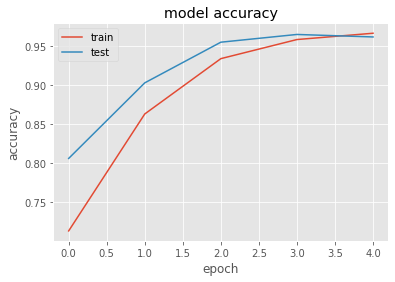

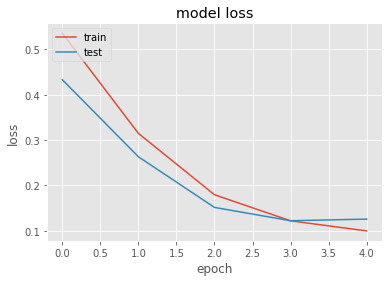

In [54]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
tokenizer.fit_on_texts(list(x_test))
sequences = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_test = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

data_test

Found 4249 unique tokens.


array([[ 13, 267,  78, ...,   0,   0,   0],
       [191, 270, 416, ...,   0,   0,   0],
       [ 13, 522,   2, ...,   0,   0,   0],
       ...,
       [ 40, 663, 676, ...,   0,   0,   0],
       [197,   1,  49, ...,   0,   0,   0],
       [  2, 822,  45, ...,   0,   0,   0]])

In [65]:
yhat = model.predict(data_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]
type(preds_labels)

list

In [61]:
from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, average_precision_score, precision_recall_curve

print(multilabel_confusion_matrix(y_test, preds_labels))

print(average_precision_score(y_test, preds_labels))
print(f1_score(y_test, preds_labels, average='micro'))
print('ROC-AUC Score:', roc_auc_score(y_test, preds_labels))

[[[302 321]
  [166 318]]

 [[591  30]
  [128 358]]

 [[329 168]
  [191 419]]

 [[912   5]
  [ 16 174]]

 [[906   8]
  [  8 185]]]
0.7531529288254438
0.7363889592301848
ROC-AUC Score: 0.803908280833555


### Preparing for submission

In [142]:
BATCH_SIZE = 128
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.15

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token = "")
tokenizer.fit_on_texts(list(train_input))
embedded_sentence = tokenizer.texts_to_sequences(train_input)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(embedded_sentence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
data.shape

Found 4250 unique tokens.


(7380, 100)

In [146]:
embedding_mat = np.zeros((MAX_NUM_WORDS,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = word_embedding.get(word)
    if embedding_vector is not None:
        embedding_mat[index] = embedding_vector
        
embedding_mat.shape

(10000, 100)

In [147]:
tokens_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64', name="SentencesInput")
embedded_sequences = Embedding(MAX_NUM_WORDS,100, weights = [embedding_mat], 
                             input_length = MAX_SEQUENCE_LENGTH, trainable = False)(tokens_input)
x = Conv1D(512, 5, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(256, 2, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
final = Dense(5, activation='sigmoid')(x)

model = Model(inputs=[tokens_input], outputs=[final])
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SentencesInput (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 96, 512)           256512    
_________________________________________________________________
dropout_44 (Dropout)         (None, 96, 512)           0         
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 18, 256)           262400    
_________________________________________________________________
dropout_45 (Dropout)         (None, 18, 256)           0  

In [148]:

model.compile(loss='binary_crossentropy', optimizer="adam",  metrics=['accuracy'])
history = model.fit(data[:-100], train_labels[:-100], epochs=5, 
                    batch_size=BATCH_SIZE, validation_data=(data[-100:], train_labels[-100:]), verbose=1)

Train on 7280 samples, validate on 100 samples
Epoch 1/5
7280/7280 [==============================] - 22s 3ms/sample - loss: 0.5381 - accuracy: 0.7075 - val_loss: 0.4551 - val_accuracy: 0.8500
Epoch 2/5
7280/7280 [==============================] - 25s 3ms/sample - loss: 0.2574 - accuracy: 0.8960 - val_loss: 0.1830 - val_accuracy: 0.9440
Epoch 3/5
7280/7280 [==============================] - 22s 3ms/sample - loss: 0.1486 - accuracy: 0.9481 - val_loss: 0.1387 - val_accuracy: 0.9540
Epoch 4/5
7280/7280 [==============================] - 19s 3ms/sample - loss: 0.1078 - accuracy: 0.9638 - val_loss: 0.1066 - val_accuracy: 0.9680
Epoch 5/5
7280/7280 [==============================] - 19s 3ms/sample - loss: 0.0877 - accuracy: 0.9702 - val_loss: 0.1025 - val_accuracy: 0.9640


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


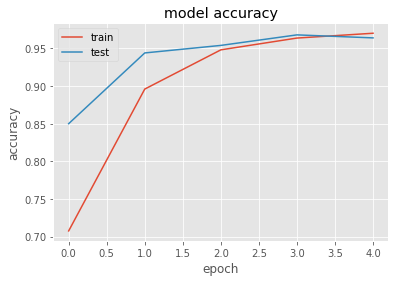

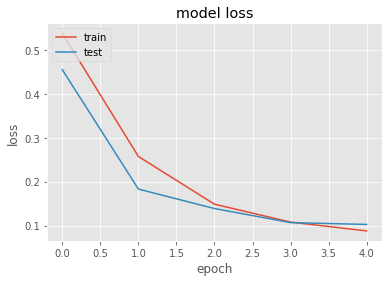

In [149]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [150]:
tokenizer.fit_on_texts(list(test_input))
sequences = tokenizer.texts_to_sequences(test_input)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_test = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

data_test

Found 4621 unique tokens.


array([[ 27, 556,  16, ...,   0,   0,   0],
       [ 33, 329, 103, ...,   0,   0,   0],
       [ 45,  47,  29, ...,   0,   0,   0],
       ...,
       [ 27, 254, 445, ...,   0,   0,   0],
       [ 15, 784, 192, ...,   0,   0,   0],
       [ 29,  47, 136, ...,   0,   0,   0]])

In [151]:
yhat = model.predict(data_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]

In [154]:
labels = pd.DataFrame(preds_labels, columns = ["outwear", "top", "trousers", "women dresses", "women skirts"])
output = pd.concat([test_id , labels], axis = 1)
output.head(3)
output.to_csv('submission1.csv',index = False)